In [80]:
import networkx as nx
import random
import matplotlib.pyplot as plt
from cynetdiff.utils import networkx_to_ic_model
import numpy as np
from coloraide import Color
import heapq
import time

Graph = nx.Graph | nx.DiGraph

In [2]:
def create_plot_for_nodes_infected_perc(
    graphs: Graph | list[Graph],
    plot_iqr: bool = False,
):
    # TODO Dhemath, see if there's a way to fix the bar running out on the shorter experiments.
    """
    Create a plot of the percentage of nodes infected for a CyNetDiff model across multiple trials for up to four graphs.
    If plot_iqr is True, plots the interquartile range and horizontal lines.
    """

    if not isinstance(graphs, list):
        graphs = [graphs]

    # Generate distinct colors for each graph using Coloraide
    colors = [Color.random("srgb") for _ in graphs]

    # Generate distinct lighter-colors for each graph for IQR plotting
    light_colors = []
    for color_str in colors:
        color = Color(color_str, "srgb")
        color[3]=0.5
        light_colors.append(color)
        

    max_length = 0
    all_graphs_data = []

    #Get all the data for graphs
    for graph in graphs:
        model = networkx_to_ic_model(graph)
        seeds = set(random.sample(list(graph.nodes()), 100))
        model.set_seeds(seeds)
        num_trials = 100

        all_trials_infected_nodes = []

        for _ in range(num_trials):
            model.reset_model()

            infected_nodes_over_time = []
            previous_activated = -1
            current_activated = 0

            while previous_activated != current_activated:
                previous_activated = current_activated
                model.advance_model()
                current_activated = model.get_num_activated_nodes()
                number_infected = current_activated
                infected_nodes_over_time.append(number_infected)

            all_trials_infected_nodes.append(infected_nodes_over_time)
            max_length = max(max_length, len(infected_nodes_over_time))

        all_graphs_data.append(all_trials_infected_nodes)

    #Pad all data
    padded_all_graphs_data = []
    for graph_data in all_graphs_data:
        padded_trials = [
            trial + [trial[-1]] * (max_length - len(trial))
            for trial in graph_data
        ]
        padded_all_graphs_data.append(padded_trials)

    #Graph Data
    for idx, graph_data in enumerate(padded_all_graphs_data):
        median_infected = np.median(graph_data, axis=0)
        
        if plot_iqr:
            iqr_values = [
                np.percentile(
                    [
                        trial[i] if i < len(trial) else trial[-1]
                        for trial in graph_data
                    ],
                    [25, 75],
                )
                for i in range(max_length)
            ]
            lower_quartile, upper_quartile = zip(*iqr_values)

            for y in median_infected:
                plt.axhline(y=y, color=colors[idx], linestyle="--", alpha=0.2)

            plt.fill_between(
                range(max_length),
                lower_quartile,
                upper_quartile,
                color=light_colors[idx],
                alpha=0.3,
            )

        plt.plot(
            median_infected, label=f"Graph {idx+1} Median Infected", color=colors[idx]
        )

    plt.xlabel("Iteration")
    plt.ylabel("Number of Infected Nodes")
    plt.title("Diffusion Process Over Time")
    plt.legend()
    plt.show()

In [3]:
def create_plot_for_delta_nodes_infected(
    graph1: nx.Graph,
    graph2: nx.Graph = None,
    graph3: nx.Graph = None,
    graph4: nx.Graph = None,
    plot_iqr: bool = False,
):
    """
    Create a plot of the delta of nodes infected for a CyNetDiff model across multiple trials for up to four graphs.
    If plot_iqr is True, plots the interquartile range and horizontal lines.
    """
    graphs = [g for g in [graph1, graph2, graph3, graph4] if g is not None]
    for graph in graphs:
        model = networkx_to_ic_model(graph)
        seeds = set(random.sample(list(graph.nodes()), 100))
        model.set_seeds(seeds)
        num_trials = 1

        all_trials_delta_nodes = []
        max_length = 0

        for _ in range(num_trials):
            model.reset_model()

            delta_nodes_over_time = []
            previous_activated = -1
            current_activated = 0

            while previous_activated != current_activated:
                previous_activated = current_activated
                model.advance_model()
                current_activated = model.get_num_activated_nodes()
                delta_nodes_over_time.append(current_activated - previous_activated)

            max_length = max(max_length, len(delta_nodes_over_time))
            all_trials_delta_nodes.append(delta_nodes_over_time)

        padded_trials = [
            trial + [0] * (max_length - len(trial)) for trial in all_trials_delta_nodes
        ]

        median_delta = np.median(padded_trials, axis=0)

        if plot_iqr:
            iqr_values = [
                np.percentile(
                    [trial[i] if i < len(trial) else 0 for trial in padded_trials],
                    [25, 75],
                )
                for i in range(max_length)
            ]
            lower_quartile, upper_quartile = zip(*iqr_values)

            for y in median_delta:
                plt.axhline(y=y, color="gray", linestyle="--", alpha=0.2)

            plt.fill_between(
                range(len(lower_quartile)),
                lower_quartile,
                upper_quartile,
                color="#7daec7",
                alpha=0.3,
            )

        plt.plot(median_delta, label="Median Delta Nodes", color="#3f83a6")

    plt.xlabel("Iteration")
    plt.ylabel("Delta Nodes Infected")
    plt.title("Diffusion Process Over Time")
    plt.legend()
    plt.show()

In [48]:
# O = nx.fast_gnp_random_graph(15000, 2)
graphs = []

base_graph = nx.watts_strogatz_graph(15_000, 10, 0.01)



graphs=[
   nx.watts_strogatz_graph(15_000, 10, 0.01),
   nx.watts_strogatz_graph(15_000, 10, 0.02),
   nx.watts_strogatz_graph(15_000, 10, 0.05),
   nx.watts_strogatz_graph(15_000, 10, 0.10),
   nx.watts_strogatz_graph(15_000, 10, 0.20),
]
graph=nx.watts_strogatz_graph(15_000, 10, 0.01)
# B = nx.erdos_renyi_graph(100, 0.1)
# nx.set_edge_attributes(G, 0.01, "activation_prob")
# nx.set_edge_attributes(O, 0.01, "activation_prob")
# nx.set_edge_attributes(B, 0.01, "activation_prob")

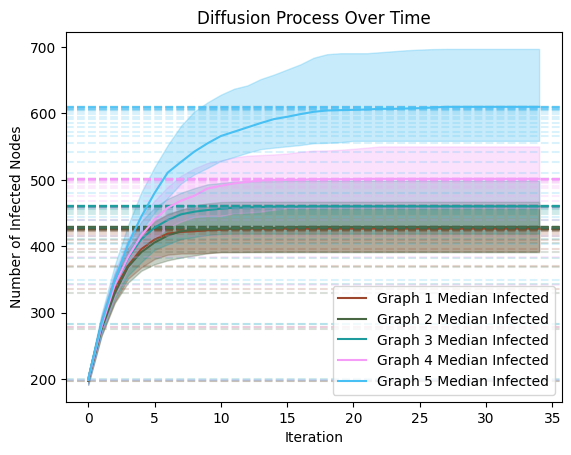

In [49]:
create_plot_for_nodes_infected_perc(graphs,True)

In [50]:
def compute_marginal_gain(model, new_node, seeds, num_trials: int = 1) -> float:
    """
    Compute the marginal gain in the spread of influence by adding a new node to the set of seed nodes,
    by summing the differences of spreads for each trial and then taking the average.
    
    Parameters:
    - model: The model used for simulating the spread of influence.
    - new_node: The new node to consider adding to the set of seed nodes.
    - seeds: The current set of seed nodes.
    - num_trials: The number of trials to average the spread of influence over.
    
    Returns:
    - The average marginal gain in the spread of influence by adding the new node.
    """
    original_spread=0
    new_spread=0
    
    model.set_seeds(seeds)

    for _ in range(num_trials):
        model.reset_model()
        model.advance_until_completion()
        original_spread += model.get_num_activated_nodes()

    new_seeds = seeds.union({new_node})
    model.set_seeds(new_seeds)

    for _ in range(num_trials):
        model.reset_model()
        model.advance_until_completion()
        new_spread += model.get_num_activated_nodes()
        
    avg_marginal_gain = (original_spread / num_trials)-(new_spread / num_trials)

    return avg_marginal_gain


In [51]:
len(sorted(graphs[1].nodes()))

15000

In [52]:
model = networkx_to_ic_model(graph[0])
compute_marginal_gain(model,12, set(random.sample(list(graphs[0].nodes()), 100)))

18.0

In [92]:
def celf(graph, k, p=0.1, mc=1000):
    """
    Input: graph object, number of seed nodes
    Output: optimal seed set, resulting spread, time for each iteration
    """
    
    start_time = time.time() 
    marg_gain = [(compute_marginal_gain(graph, node, set(), mc), node) for node in (graph.nodes())]
    
    heapq.heapify(marg_gain)
    marg_gain = [heapq.heappop(marg_gain) for _ in range(len(marg_gain))]
    marg_gain = [(-mg, node) for mg, node in marg_gain] 
    heapq.heapify(marg_gain)
    
    max_mg, selected_node = heapq.heappop(marg_gain)
    S, spread, SPREAD = [selected_node], -max_mg, [-max_mg]
    LOOKUPS, timelapse = [graph.nodes()], [time.time()-start_time]

    model = networkx_to_ic_model(graph)
    
    for _ in range(k-1):
        while True:
            current_mg, current_node = heapq.heappop(marg_gain)
            
            new_mg = compute_marginal_gain(model, current_node, set(S), mc)
            new_mg_neg = -new_mg 
            
            if new_mg_neg > current_mg:
                heapq.heappush(marg_gain, (new_mg_neg, current_node))
                break  
            else:
                heapq.heappush(marg_gain, (current_mg, current_node))
                
        spread += -new_mg_neg
        S.append(current_node)
        SPREAD.append(spread)
        LOOKUPS.append(len(marg_gain) + 1)  
        timelapse.append(time.time() - start_time)
    
    return S, SPREAD, LOOKUPS

In [93]:
graph=nx.watts_strogatz_graph(1_000, 10, 0.01)
celf(graph,10,1,1)

([500, 777, 11, 293, 878, 301, 804, 104, 6, 93],
 [43.0, 39.0, 50.0, 36.0, 8.0, -4.0, 3.0, 20.0, 35.0, 22.0],
 [NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197